In [58]:
import pyomo.opt 
import pyomo.environ as pe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 1.2.9 Método para análise estratégica: Análise estratégica de dados para alinhamento das outorgas portuárias

## Modelo custo de fluxo mínimo multiproduto em redes

### Primal

\begin{aligned}
& \underset{x_{ij}^k}{\text{minimizar}} & &\sum_{k \in OD}\sum_{(i,j) \in E} c_{ij}x_{ij}^k &\\
& \text{sujeito a}  & & \sum_{k\in K} x_{ij}^k \leq u_{ij} & \forall (i,j) \in E\\
&                   & & \sum_{i:(i,v)\in E} x_{iv}^k - \sum_{j:(v,j)\in E} x_{vj}^k = 0 & \forall v \in V, \forall k \in OD \; \mid \;v \notin OD_1 \cup OD_2\\
&                   & & \sum_{i:(i,v)\in E} x_{iv}^k - \sum_{j:(v,j)\in E} x_{vj}^k = d^k & \forall v \in V, \forall k \in OD \; \mid \;v \in OD_1 \\
&                   & & \sum_{i:(i,v)\in E} x_{iv}^k - \sum_{j:(v,j)\in E} x_{vj}^k = -d^k & \forall v \in V, \forall k \in OD \; \mid \;v \in OD_2 \\
&                   & & x_{ij}^k \geq 0 & \forall (i,j) \in E \quad \forall k \in OD.
\end{aligned}

### Dual

\begin{aligned}
& \underset{x_{ij}^k}{\text{maximizar}} & &\sum_{k \in OD}\sum_{v \in V} \pi_v^kd^k - \sum_{(i,j) \in E} d_{ij}\mu_{ij}&\\
& \text{sujeito a}  & & \pi_i^k - \pi_j^k - \mu_{ij} = c_{ij} & \forall (i,j) \in E, \; \forall k \in OD\\
&                   & & \pi_i^k \in \mathbb{R} \quad \mu_{ij} \geq 0
\end{aligned}

## Dados de entrada

In [59]:
origens = ["SP", "SC"]
destinos = ["USA", "EU"]
portos = ["Itapoá", "SFS"]

origem_destino = [(o,d) for o in origens for d in destinos]
demanda_origem_destino = {  origem_destino[0]:4, 
                            origem_destino[1]:5,
                            origem_destino[2]:2, 
                            origem_destino[3]:1 }

#Conjunto E

portos_v = [(p+"-in", p+"-out") for p in portos]

arcos = [(origens[0], portos_v[0][0]), (origens[0], portos_v[1][0]), (origens[1], portos_v[0][0]), (origens[1], portos_v[1][0]),
         (portos_v[0][0], portos_v[0][1]), (portos_v[1][0], portos_v[1][1]),
         (portos_v[0][1], destinos[0]), (portos_v[1][1], destinos[0]), (portos_v[0][1], destinos[1]), (portos_v[1][1], destinos[1])]#,
         #(origens[0], destinos[0]), (origens[0], destinos[1]), (origens[1], destinos[0]), (origens[1], destinos[1])]

#Conjunto V
vertices = list(set().union(origens,destinos))
for porto_v in portos_v:
    vertices = list(set().union(vertices,porto_v))

# c_ij
custo_transporte = {arcos[0]:.205, 
                    arcos[1]:.190,
                    arcos[2]:.275,
                    arcos[3]:.245,
                    arcos[4]:.450,
                    arcos[5]:.545,
                    arcos[6]:.045,
                    arcos[7]:.025,
                    arcos[8]:.030,
                    arcos[9]:.055}
#                     arcos[10]:1000,
#                     arcos[11]:1000,
#                     arcos[12]:1000,
#                     arcos[13]:1000}

# u_ij
capacidades_arcos = {arcos[0]:100,
                     arcos[1]:100,
                     arcos[2]:100,
                     arcos[3]:100,
                     arcos[4]:7,
                     arcos[5]:5,
                     arcos[6]:100,
                     arcos[7]:100,
                     arcos[8]:100,
                     arcos[9]:100}
#                      arcos[10]:1000,
#                      arcos[11]:1000,
#                      arcos[12]:1000,
#                      arcos[13]:1000}

In [60]:
arcos

[('SP', 'Itapoá-in'),
 ('SP', 'SFS-in'),
 ('SC', 'Itapoá-in'),
 ('SC', 'SFS-in'),
 ('Itapoá-in', 'Itapoá-out'),
 ('SFS-in', 'SFS-out'),
 ('Itapoá-out', 'USA'),
 ('SFS-out', 'USA'),
 ('Itapoá-out', 'EU'),
 ('SFS-out', 'EU')]

Demandas
('SP', 'USA') 4
('SP', 'EU') 5
('SC', 'USA') 2
('SC', 'EU') 1


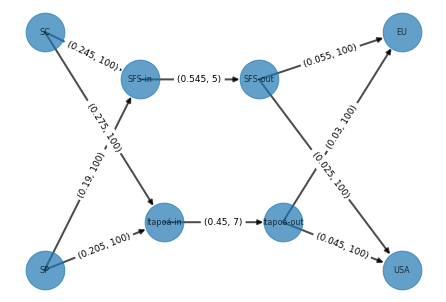

In [61]:
def create_networkx_nodes(rede:nx.DiGraph(), nos:list, x:int, y:int=0):
    for index, no in enumerate(nos):
        rede.add_node(no, pos=(x, index*5 if y == 0 else y))        
def create_networkx(edge_labels: dict):
    rede = nx.DiGraph()   
    create_networkx_nodes(rede, origens, 0)
    create_networkx_nodes(rede, [portos_v[0][0]], 10, 1)
    create_networkx_nodes(rede, [portos_v[0][1]], 20, 1)
    create_networkx_nodes(rede, [portos_v[1][0]], 8, 4)
    create_networkx_nodes(rede, [portos_v[1][1]], 18, 4)
    create_networkx_nodes(rede, destinos, 30)    
    for edge in arcos:         
        rede.add_edge(*edge, weight=custo_transporte[edge], capacity=capacidades_arcos[edge])
    pos=nx.get_node_attributes(rede,'pos')
    nx.draw(rede, pos, with_labels=True, node_size=1500, alpha=0.7, arrows=True, font_size=8, width=[2 if custo_transporte[e] < 1000 else .2 for e in rede.edges()])        
    labels_return=nx.draw_networkx_edge_labels(rede, pos,edge_labels=edge_labels,font_size=9)
    return rede

edge_labels = {}
for edge in arcos:
    if custo_transporte[edge] < 1000:               
        edge_labels[edge] = (custo_transporte[edge], capacidades_arcos[edge])   
rede = create_networkx(edge_labels)

print("Demandas")
for od, value in demanda_origem_destino.items():   
    print(od, value)

## Formulação de modelo concreto: Custo mínimo multi produto em redes 

In [62]:
def multicommodity_minimum_cost_flow(_vertices, _arcos, _origem_destino, _demanda_origem_destino, _capacidades_arcos):
    modelo = pe.ConcreteModel(name="(demanda_porto)")

    modelo.node_set = pe.Set( initialize=_vertices )
    modelo.edge_set = pe.Set( initialize=_arcos, dimen=2)
    modelo.commodity_set = pe.Set( initialize=_origem_destino, dimen=2)
    modelo.dual = pe.Suffix(direction=pe.Suffix.IMPORT)

    modelo.var_indexes = pe.Set(initialize=modelo.edge_set*modelo.commodity_set)
    modelo.var = pe.Var(modelo.var_indexes, within=pe.NonNegativeReals)

    def objetivo(m):
        return sum(custo_transporte[(index[0], index[1])] * m.var[index] for index in modelo.var_indexes)     
    modelo.obj = pe.Objective(rule=objetivo, sense=pe.minimize)

    def conserva_fluxo(m, i, o, d):
        from_i = [v for v in _arcos if v[0] == i]
        to_i = [v for v in _arcos if v[1] == i]                
        q =  _demanda_origem_destino[(o,d)] if i == o else -_demanda_origem_destino[(o,d)] if i == d else 0
        return sum(m.var[v,(o,d)] for v in from_i) - sum(m.var[v,(o,d)] for v in to_i) == q

    modelo.conserva_fluxo_indexes = pe.Set(initialize=modelo.node_set*modelo.commodity_set)
    modelo.flowConservation = pe.Constraint(modelo.conserva_fluxo_indexes, rule=conserva_fluxo)

    def capacidades(m, e1,e2):
        return sum(m.var[e1,e2,o,d] for (o,d) in modelo.commodity_set) <= _capacidades_arcos[(e1,e2)]
    modelo.capacidade_arco = pe.Constraint(modelo.edge_set, rule=capacidades)

    solver = pyomo.opt.SolverFactory('cbc')
    results = solver.solve(modelo)
    return modelo

In [63]:
modelo = multicommodity_minimum_cost_flow(vertices, arcos, origem_destino, demanda_origem_destino, capacidades_arcos)

## Apresenta resultados
### Análise dos Fluxos

{'Itapoá': 7.0, 'SFS': 5.0}


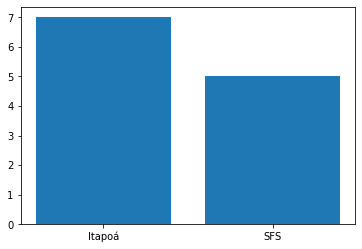

In [64]:
demanda_porto = {}
for porto in portos:
    total = 0
    for var_index in modelo.var_indexes:
        if (var_index[0], var_index[1]) == (porto+"-in", porto+"-out"):
            total += modelo.var[var_index].value
    demanda_porto[porto] = total

print(demanda_porto)

from matplotlib import rcParams
color = 'black'
rcParams['xtick.color'] = color
rcParams['ytick.color'] = color
rcParams['axes.labelcolor'] = color
rcParams['axes.edgecolor'] = color
plt.bar(range(len(demanda_porto)),list(demanda_porto.values()),tick_label=list(demanda_porto.keys()))
plt.show()

### Fluxo agregado

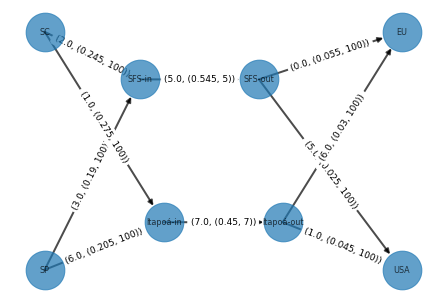

In [65]:
fluxo_arco = {}
for var_index in modelo.var_indexes:
    if fluxo_arco.get((var_index[0], var_index[1])) is not None:
        fluxo_arco[(var_index[0], var_index[1])] = fluxo_arco[(var_index[0], var_index[1])] + modelo.var[var_index].value
    else:
        fluxo_arco[(var_index[0], var_index[1])] = modelo.var[var_index].value

edge_labels = {}
for edge in arcos:
    #if custo_transporte[edge] < 1000:                    
        edge_labels[edge] = (fluxo_arco[edge], (custo_transporte[edge], capacidades_arcos[edge]))
rede_fluxo = create_networkx(edge_labels)

In [66]:
def show_flow(od: tuple):
    edge_labels = {}
    for var_index in modelo.var_indexes:
        edge = var_index[0:2]
        if var_index[2:4] == od and modelo.var[var_index].value > 0: #and custo_transporte[edge] < 1000:            
            edge_labels[edge] = (modelo.var[var_index].value, (custo_transporte[edge], capacidades_arcos[edge])) if modelo.var[var_index].value > 0 else (custo_transporte[edge], capacidades_arcos[edge])
    rede_fluxo = create_networkx(edge_labels)

### Fluxos por OD

1

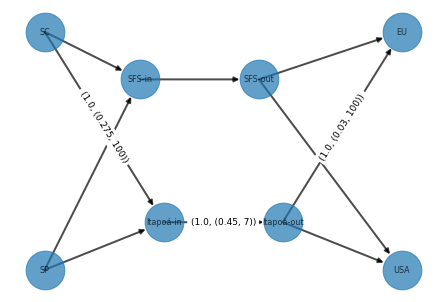

In [67]:
show_flow(("SC", "EU"))
demanda_origem_destino[("SC", "EU")]

2

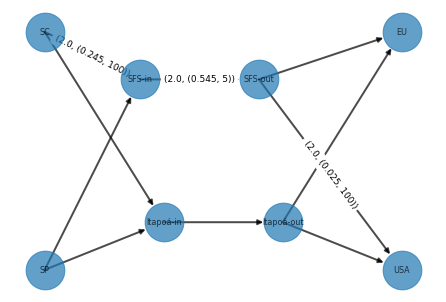

In [68]:
show_flow(("SC", "USA"))
demanda_origem_destino[("SC", "USA")]

4

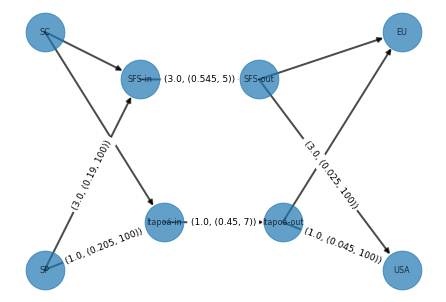

In [69]:
show_flow(("SP", "USA"))
demanda_origem_destino[("SP", "USA")]

1

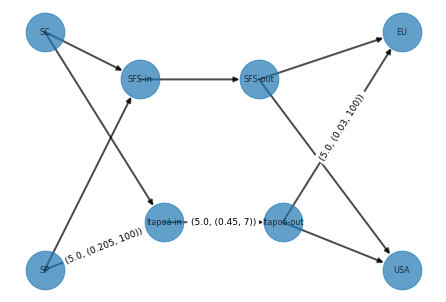

In [70]:
show_flow(("SP", "EU"))
demanda_origem_destino[("SC", "EU")]

### Análise das variáveis duais

In [71]:
#def get_duals(modelo)
duals_by_constraint = {}
for c in modelo.component_objects(pe.Constraint, active=True):
    duals_by_constraint[c] = {}
    print ("   Restrição",c)
    for index in c:
        duals_by_constraint[c][index] = modelo.dual[c[index]]
        #print ("      ", index, modelo.dual[c[index]])
#modelo.dual.display()
#print(duals_by_constraint)

   Restrição flowConservation
   Restrição capacidade_arco


In [72]:
def get_constraint_flow_duals(modelo):
    duals = {}
    for c in modelo.component_objects(pe.Constraint, active=True):
        if c.name == "flowConservation":
            #print ("   Restrição",c)
            for index in c:
                duals[index] = modelo.dual[c[index]]
                #print ("      ", index, modelo.dual[c[index]])
    #modelo.dual.display()
    return duals

In [73]:
modelo = multicommodity_minimum_cost_flow(vertices, arcos, origem_destino, demanda_origem_destino, capacidades_arcos)
price = get_constraint_flow_duals(modelo)
price_out = {}
for key, value in price.items():
    if key[0] in ['Itapoá-out', 'SFS-out', 'Itapoá-in', 'SFS-in']:
        price_out[key] = value
#price_out

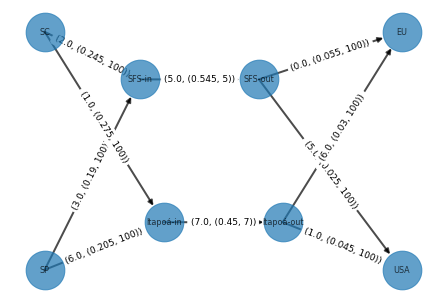

In [74]:
rede_fluxo = create_networkx(edge_labels)

In [75]:
for var_index in modelo.var_indexes:
    #if (var_index[0], var_index[1]) == (porto+"-in", porto+"-out"):
    print(var_index, modelo.var[var_index].value)

('SP', 'Itapoá-in', 'SP', 'USA') 1.0
('SP', 'Itapoá-in', 'SP', 'EU') 5.0
('SP', 'Itapoá-in', 'SC', 'USA') 0.0
('SP', 'Itapoá-in', 'SC', 'EU') 0.0
('SP', 'SFS-in', 'SP', 'USA') 3.0
('SP', 'SFS-in', 'SP', 'EU') 0.0
('SP', 'SFS-in', 'SC', 'USA') 0.0
('SP', 'SFS-in', 'SC', 'EU') 0.0
('SC', 'Itapoá-in', 'SP', 'USA') 0.0
('SC', 'Itapoá-in', 'SP', 'EU') 0.0
('SC', 'Itapoá-in', 'SC', 'USA') -0.0
('SC', 'Itapoá-in', 'SC', 'EU') 1.0
('SC', 'SFS-in', 'SP', 'USA') 0.0
('SC', 'SFS-in', 'SP', 'EU') 0.0
('SC', 'SFS-in', 'SC', 'USA') 2.0
('SC', 'SFS-in', 'SC', 'EU') 0.0
('Itapoá-in', 'Itapoá-out', 'SP', 'USA') 1.0
('Itapoá-in', 'Itapoá-out', 'SP', 'EU') 5.0
('Itapoá-in', 'Itapoá-out', 'SC', 'USA') 0.0
('Itapoá-in', 'Itapoá-out', 'SC', 'EU') 1.0
('SFS-in', 'SFS-out', 'SP', 'USA') 3.0
('SFS-in', 'SFS-out', 'SP', 'EU') 0.0
('SFS-in', 'SFS-out', 'SC', 'USA') 2.0
('SFS-in', 'SFS-out', 'SC', 'EU') 0.0
('Itapoá-out', 'USA', 'SP', 'USA') 1.0
('Itapoá-out', 'USA', 'SP', 'EU') 0.0
('Itapoá-out', 'USA', 'SC', 'U

Text(0.5, 0.98, 'Estudo Inicial preço x capacidade')

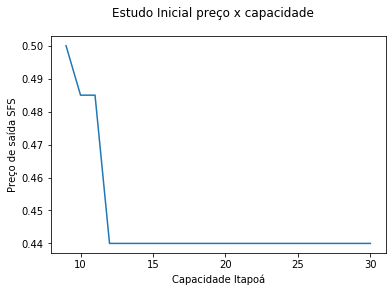

In [76]:
price_out_by_capacity = {}
demanda_porto_od_by_capacity = {}
for cap_itapoa in range(9, 31):
    capacidades_arcos[('Itapoá-in', 'Itapoá-out')] = cap_itapoa
    #capacidades_arcos[('SFS-in', 'SFS-out')] = cap_itapoa
    modelo = multicommodity_minimum_cost_flow(vertices, arcos, origem_destino, demanda_origem_destino, capacidades_arcos)
    price = get_constraint_flow_duals(modelo)
    price_out_by_capacity[cap_itapoa] = {}
    for key, value in price.items():        
        if key[0] in ['Itapoá-out', 'SFS-out']:
            price_out_by_capacity[cap_itapoa][key] = value
    demanda_porto_od_by_capacity[cap_itapoa] = {}
    for porto in portos:
        #total = 0
        for var_index in modelo.var_indexes:
            if (var_index[0], var_index[1]) == (porto+"-in", porto+"-out"):
                #total += modelo.var[var_index].value
                demanda_porto_od_by_capacity[cap_itapoa][var_index] = modelo.var[var_index].value

x_capacidades = []
y_precos = []
for cap_itapoa, value in demanda_porto_od_by_capacity.items():
    #print(cap_itapoa)
    x_capacidades.append(cap_itapoa)
    for price_key, price in price_out_by_capacity[cap_itapoa].items():
        #print("price",price_key, price)
        if price_key == ('SFS-out', 'SP', 'EU'):
            y_precos.append(-price)
    for key2, value2 in value.items():
        #print("flow", key2, value2)
        pass
fig = plt.figure()
plt.plot(x_capacidades, y_precos)
plt.xlabel('Capacidade Itapoá')
plt.ylabel('Preço de saída SFS')
fig.suptitle('Estudo Inicial preço x capacidade')